<a href="https://colab.research.google.com/github/IssamBenamara/SIFT_BOW/blob/master/REDS_Data_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualisation et réduction de dimension

_Ismaël Bonneau & Issam Benamara_


On reprend les données du boson de Higgs...

On a un ensemble de features dont certaines comportent énormément de données manquantes, et 3 ne sont pas à considérer comme features: il s'agit de EventId, Weight, et Label

In [0]:
!wget https://github.com/ismaelbonneau/REDS/raw/master/data/training.csv

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

np.random.seed(42)

In [3]:
data = pd.read_csv("training.csv",na_values=-999).drop(columns=['Weight','EventId'])
data.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,s
1,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,0.879,1.414,NaN,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226,b
2,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,3.776,1.414,NaN,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251,b
3,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,2.354,-1.285,NaN,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000,b
4,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,1.056,-1.385,NaN,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,b


In [4]:
data.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,211886.000000,250000.000000,250000.000000,250000.000000,72543.000000,72543.000000,72543.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,72543.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,150087.000000,150087.000000,150087.000000,72543.000000,72543.000000,72543.000000,250000.000000
mean,121.858528,49.239819,81.181982,57.895962,2.403735,371.783360,-0.821688,2.373100,18.917332,158.432217,1.437609,-0.128305,0.458290,38.707419,-0.010973,-0.008171,46.660207,-0.019507,0.043543,41.717235,-0.010119,209.797178,0.979176,84.822105,-0.003275,-0.012393,57.679474,-0.011845,-0.001582,73.064591
std,57.298157,35.344886,40.828691,63.655682,1.742226,397.699325,3.584362,0.782911,22.273494,115.706115,0.844743,1.193585,0.398681,22.412081,1.214079,1.816763,22.064922,1.264982,1.816611,32.894693,1.812223,126.499506,0.977426,60.662276,1.784546,1.813385,31.985782,2.031743,1.816950,98.015662
min,9.044000,0.000000,6.329000,0.000000,0.000000,13.602000,-18.066000,0.208000,0.000000,46.104000,0.047000,-1.414000,0.000000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.678000,0.000000,30.000000,-4.499000,-3.142000,30.000000,-4.500000,-3.142000,0.000000
25%,91.885250,19.241000,59.388750,14.068750,0.882500,111.977000,-2.629000,1.810000,2.841000,77.550000,0.883000,-1.371000,0.004000,24.591750,-0.925000,-1.575000,32.375000,-1.014000,-1.522000,21.398000,-1.575000,123.017500,0.000000,44.422500,-1.342000,-1.584000,37.312000,-1.612000,-1.576500,0.000000
50%,112.406000,46.524000,73.752000,38.467500,2.107000,225.885000,-0.244000,2.491500,12.315500,120.664500,1.280000,-0.356000,0.454000,31.804000,-0.023000,-0.033000,40.516000,-0.045000,0.086000,34.802000,-0.024000,179.739000,1.000000,65.561000,0.000000,-0.033000,47.902000,-0.010000,-0.002000,40.512500
75%,135.482000,73.598000,92.259000,79.169000,3.690000,478.226000,0.958000,2.961000,27.591000,200.478250,1.777000,1.225000,0.879000,45.017000,0.898000,1.565000,53.390000,0.959000,1.618000,51.895000,1.561000,263.379250,2.000000,103.342000,1.336000,1.562000,66.637000,1.589500,1.576000,109.933750
max,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,19.773000,1.414000,1.000000,764.408000,2.497000,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


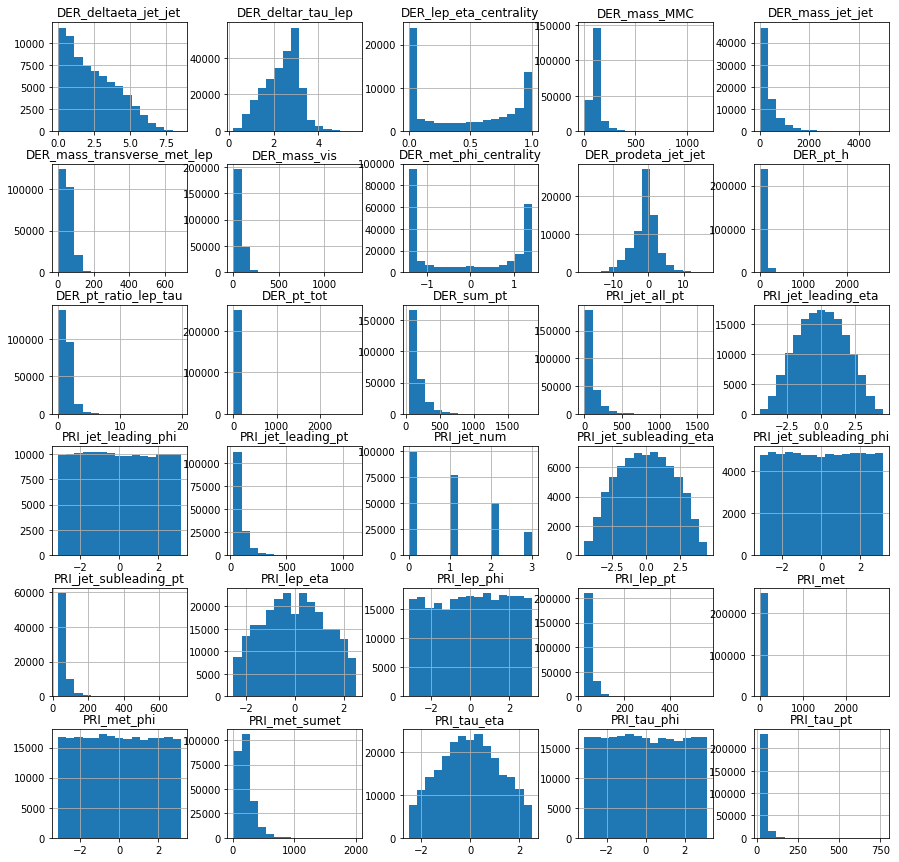

In [7]:
hist = data.hist(figsize=(15,15), bins=15)

On décide de supprimer les colonnes qui contiennent moins de données qu'un certain seuil


In [0]:
min_count = 210000
data_dropped = data.drop( columns = data.columns[data.describe(include='all').loc['count']<= min_count])

En affichant la matrice de corrélation entre les différentes features on peut selectionner quelques features à éliminer si elles sont trop corrélées entre elles


In [0]:
df = data_dropped.drop(columns=['Label'])

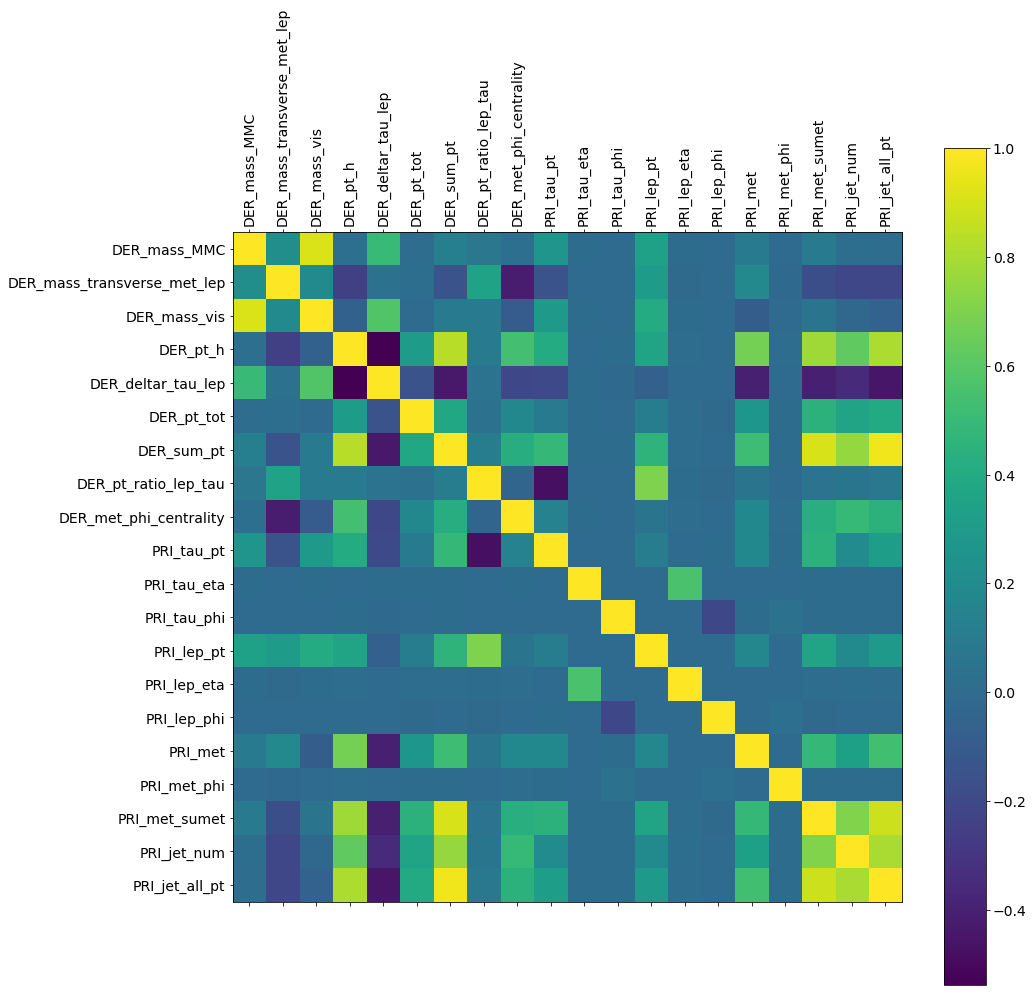

In [10]:
f = plt.figure(figsize=(15, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

On décide d'eliminer les features qui sont correlées à p >= 0.9

In [11]:
cdf = df.corr()
to_drop = []
to_not_drop = set()
for col in df.columns:
    if col in to_drop:
        continue
    if (cdf[col]>0.9).sum()>1:
        s = cdf[col][cdf[col]>0.9][cdf[col]<1]
        print(col," is highly correlated with : \n", s)
        to_not_drop.add(col)
        to_drop += s.index.tolist()
print("\nDropping")
print(to_drop)

DER_mass_MMC  is highly correlated with : 
 DER_mass_vis    0.911795
Name: DER_mass_MMC, dtype: float64
DER_sum_pt  is highly correlated with : 
 PRI_met_sumet     0.904481
PRI_jet_all_pt    0.965628
Name: DER_sum_pt, dtype: float64

Dropping
['DER_mass_vis', 'PRI_met_sumet', 'PRI_jet_all_pt']


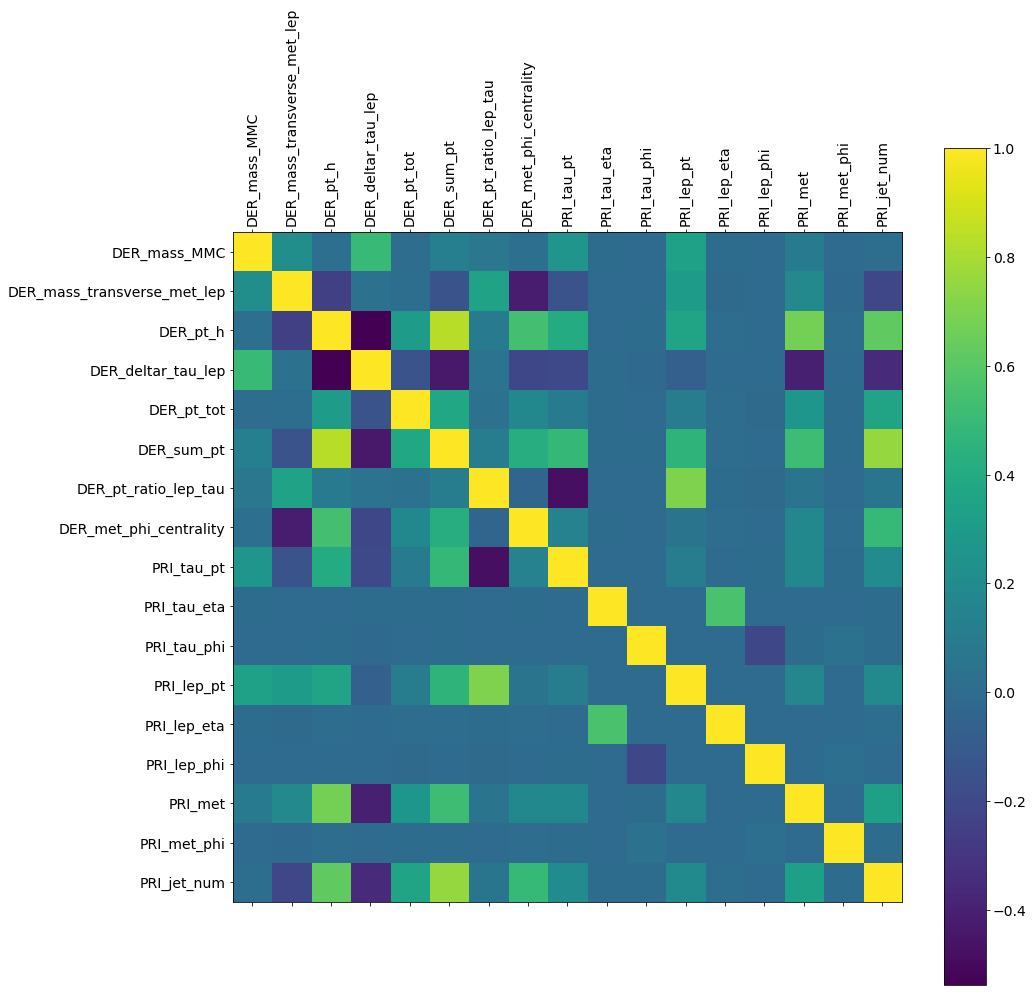

In [12]:
df_deco = df.drop(columns=to_drop)
f = plt.figure(figsize=(15, 15))
plt.matshow(df_deco.corr(), fignum=f.number)
plt.xticks(range(df_deco.shape[1]), df_deco.columns, fontsize=14, rotation=90)
plt.yticks(range(df_deco.shape[1]), df_deco.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [13]:
data_dropped = data_dropped.drop(columns=to_drop).dropna()
data_dropped.describe()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_jet_num
count,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000,211886.000000
mean,121.858528,42.001020,63.228131,2.430013,19.338716,167.645039,1.428344,0.053725,39.657081,-0.009794,-0.012684,47.208877,-0.014290,0.043263,38.261579,-0.004367,1.070845
std,57.298157,30.825474,65.765518,0.765918,21.907415,119.000718,0.859173,1.191099,22.870225,1.205610,1.816221,22.362090,1.249668,1.815649,32.651768,1.813294,0.978572
min,9.044000,0.000000,0.000000,0.224000,0.000000,46.104000,0.047000,-1.414000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,0.000000
25%,91.885250,15.751000,20.710000,1.898000,3.045000,84.118000,0.859000,-1.346000,25.116000,-0.915000,-1.576000,32.557000,-0.984000,-1.519000,19.272000,-1.570000,0.000000
50%,112.406000,37.649000,43.582000,2.575000,14.331000,130.873000,1.259000,0.315000,32.844000,-0.022000,-0.043000,41.010000,-0.036000,0.084000,30.656000,-0.012000,1.000000
75%,135.482000,63.349500,86.432500,2.993000,28.085000,212.286750,1.776000,1.293000,46.313000,0.893750,1.558000,54.235000,0.945000,1.618000,45.872000,1.566000,2.000000
max,1192.026000,594.287000,2834.999000,5.684000,2834.999000,1852.462000,19.773000,1.414000,622.862000,2.497000,3.142000,461.896000,2.502000,3.142000,2842.617000,3.142000,3.000000


#PCA

Afin d'appliquer PCA on doit d'abord centrer les features

In [0]:
features = data_dropped.columns[:-1]

In [0]:
df_deco = (data_dropped[features]-data_dropped[features].mean())

In [19]:
pca=PCA(n_components=4) 
pca.fit(df_deco) 
X_pca=pca.transform(df_deco) 
pca.explained_variance_ratio_

array([0.71996141, 0.13578212, 0.05372146, 0.03847736])

ça tombe bien les deux premieres composantes représentent 0.71+0.13 = 0.84 donc approximativement 84% de la variance ce qui est acceptable donc on peut s'attendre à une visualisation acceptable en 2D

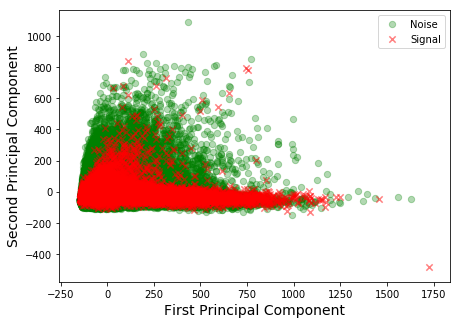

In [22]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels=data_dropped.Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()
# please check the scatter plot of the remaining component and you will understand the difference

###Remarque
On remarque que le signal est plutot concentré lorsque la deuxieme composante est proche de zéro

#KernelPCA

Pour toutes les visualisations qui suivent on choisit toujours deux composantes pour esperer "voir" quelque chose.


In [0]:
from sklearn.decomposition.kernel_pca import KernelPCA

Original number of features: 20
Reduced number of features: 2


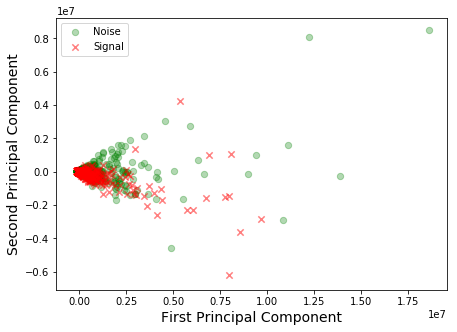

In [36]:
kpca = KernelPCA(n_components=2, kernel="poly")
df_sample = df_deco.sample(n= 10000, random_state=42)
X_kpca = kpca.fit_transform(df_sample)

print('Original number of features:', df.shape[1])
print('Reduced number of features:', X_kpca.shape[1])
X_pca = X_kpca
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels= data_dropped.loc[df_sample.index].Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

Original number of features: 20
Reduced number of features: 2


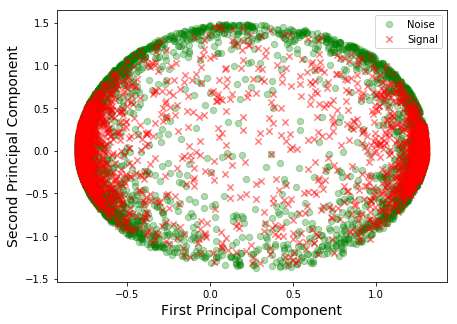

In [37]:
kpca = KernelPCA(n_components=2, kernel="sigmoid")
df_sample = df_deco.sample(n= 10000, random_state=42)
X_kpca = kpca.fit_transform(df_sample)

print('Original number of features:', df.shape[1])
print('Reduced number of features:', X_kpca.shape[1])
X_pca = X_kpca
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels= data_dropped.loc[df_sample.index].Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

Original number of features: 20
Reduced number of features: 2


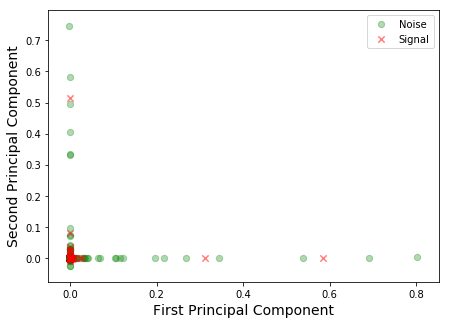

In [38]:
kpca = KernelPCA(n_components=2, kernel="rbf")
df_sample = df_deco.sample(n= 10000, random_state=42)
X_kpca = kpca.fit_transform(df_sample)

print('Original number of features:', df.shape[1])
print('Reduced number of features:', X_kpca.shape[1])
X_pca = X_kpca
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels= data_dropped.loc[df_sample.index].Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

Pour les différentes projections, on arrive toujous à la meme conclusion, il y'a des regions ou il n'y a que du bruit mais là ou il y'a du signal on remarque aussi la présence de bruit

#MDS


In [0]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
df_sample = df_deco.sample(n= 1000, random_state=1)
X_transformed = embedding.fit_transform(df_sample)

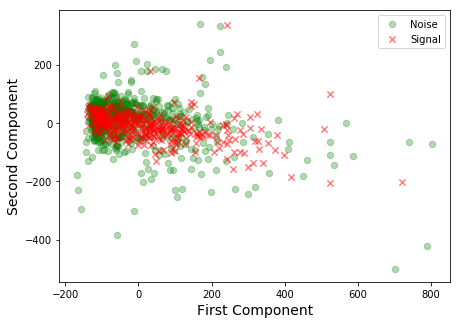

In [41]:
X_pca = X_transformed
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels= data_dropped.loc[df_sample.index].Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Component",fontsize=14)
plt.ylabel("Second Component",fontsize=14)
plt.legend()
plt.show()

In [53]:
from sklearn.manifold import TSNE
pca=PCA(n_components=10) 
pca.fit(df_deco) 
X_pca=pca.transform(df_deco)
df_sample = pd.DataFrame(X_pca,index=df_deco.index).sample(n= 2000, random_state=42)

tsne = TSNE(n_components=3, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_sample)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 11.957962
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.151184
[t-SNE] KL divergence after 1000 iterations: 0.804387


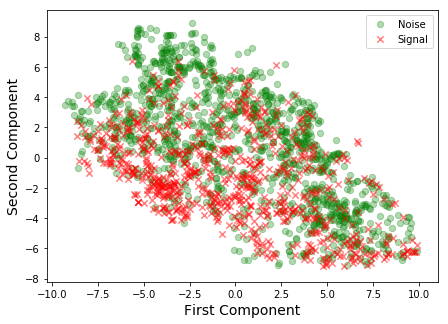

In [54]:
X_pca = tsne_results
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels= data_dropped.loc[df_sample.index].Label
cdict={'s':'red','b':'green'}
labl={'s':'Signal','b':'Noise'}
marker={'s':'x','b':'o'}
alpha={'s':.5, 'b':.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix = np.where(labels==l)[0]
 ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Component",fontsize=14)
plt.ylabel("Second Component",fontsize=14)
plt.legend()
plt.show()